In [12]:
# Cell 1 — Imports & Config
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from timm import create_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
IMG_SIZE    = 128
NUM_CLASSES = 2
NUM_SAMPLES = 100
EPSILON     = 0.03
PGD_STEPS   = 7
ALPHA       = 0.01
CLASS_NAMES = ['REAL', 'FAKE']
MODEL_PATH  = "/kaggle/input/new-model/robust_hybrid_cifake(1).pth"
TEST_DIR    = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"


In [13]:
# Cell 2 — Model Definition
class RobustHybridModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.model = create_model(
            'deit_small_patch16_224',
            pretrained=True,
            num_classes=num_classes,
            img_size=IMG_SIZE
        )
    def forward(self, x):
        return self.model(x)


In [14]:
# Cell 3 — Adversarial Attack Functions
def fgsm_attack(model, images, labels, epsilon=EPSILON):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed, 0, 1).detach()

def pgd_attack(model, images, labels, epsilon=EPSILON, alpha=ALPHA, iters=PGD_STEPS):
    perturbed = images.clone().detach()
    for _ in range(iters):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed += alpha * perturbed.grad.sign()
            perturbed = torch.max(torch.min(perturbed, images + epsilon), images - epsilon)
            perturbed = torch.clamp(perturbed, 0, 1)
    return perturbed.detach()

def one_pixel_attack(images, pixel_count=1):
    perturbed = images.clone()
    b, c, h, w = images.shape
    for i in range(b):
        for _ in range(pixel_count):
            x, y = np.random.randint(0, h), np.random.randint(0, w)
            perturbed[i, :, x, y] = torch.rand(c)
    return perturbed


In [15]:
# Cell 4 — Load Test Data
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

# Remap targets: FAKE=1, REAL=0
test_dataset.targets = [
    1 if t == test_dataset.class_to_idx['FAKE'] else 0
    for t in test_dataset.targets
]

# Sample 100 random images
indices = random.sample(range(len(test_dataset)), NUM_SAMPLES)
subset = Subset(test_dataset, indices)
loader = DataLoader(subset, batch_size=NUM_SAMPLES, shuffle=False)
images, labels = next(iter(loader))
images, labels = images.to(device), labels.to(device)


In [16]:
# Cell 5 — Load Model
model = RobustHybridModel().to(device)
ckpt = torch.load(MODEL_PATH, map_location=device)
load_result = model.load_state_dict(ckpt, strict=False)

model.eval()


/tmp/ipykernel_31/797124658.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=device)


RobustHybridModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='n

In [17]:
# Cell 6 — Generate Attacked Versions
images_fgsm  = fgsm_attack(model, images.clone(), labels)
images_pgd   = pgd_attack(model, images.clone(), labels)
images_pixel = one_pixel_attack(images.clone())


In [18]:
# Cell 7 — Run Inference
with torch.no_grad():
    pred_clean  = model(images).argmax(1).cpu()
    pred_fgsm   = model(images_fgsm).argmax(1).cpu()
    pred_pgd    = model(images_pgd).argmax(1).cpu()
    pred_pixel  = model(images_pixel).argmax(1).cpu()

true_labels = labels.cpu()

def acc(true, pred): return (true == pred).float().mean().item()

print(f"Accuracy (Clean):   {acc(true_labels, pred_clean):.2%}")
print(f"Accuracy (FGSM):    {acc(true_labels, pred_fgsm):.2%}")
print(f"Accuracy (PGD):     {acc(true_labels, pred_pgd):.2%}")
print(f"Accuracy (1-Pixel): {acc(true_labels, pred_pixel):.2%}")


Accuracy (Clean):   93.00%
Accuracy (FGSM):    71.00%
Accuracy (PGD):     68.00%
Accuracy (1-Pixel): 93.00%


In [19]:
# Cell 8 — Classification Reports (Optional)
print("\n--- Classification Report (Clean) ---")
print(classification_report(true_labels, pred_clean, target_names=CLASS_NAMES))

print("\n--- Classification Report (FGSM) ---")
print(classification_report(true_labels, pred_fgsm, target_names=CLASS_NAMES))

print("\n--- Classification Report (PGD) ---")
print(classification_report(true_labels, pred_pgd, target_names=CLASS_NAMES))

print("\n--- Classification Report (One-Pixel) ---")
print(classification_report(true_labels, pred_pixel, target_names=CLASS_NAMES))



--- Classification Report (Clean) ---
              precision    recall  f1-score   support

        REAL       0.94      0.92      0.93        48
        FAKE       0.92      0.94      0.93        52

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


--- Classification Report (FGSM) ---
              precision    recall  f1-score   support

        REAL       0.74      0.60      0.67        48
        FAKE       0.69      0.81      0.74        52

    accuracy                           0.71       100
   macro avg       0.72      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100


--- Classification Report (PGD) ---
              precision    recall  f1-score   support

        REAL       0.70      0.58      0.64        48
        FAKE       0.67      0.77      0.71        52

    accuracy                           0.68       100
   macro avg  

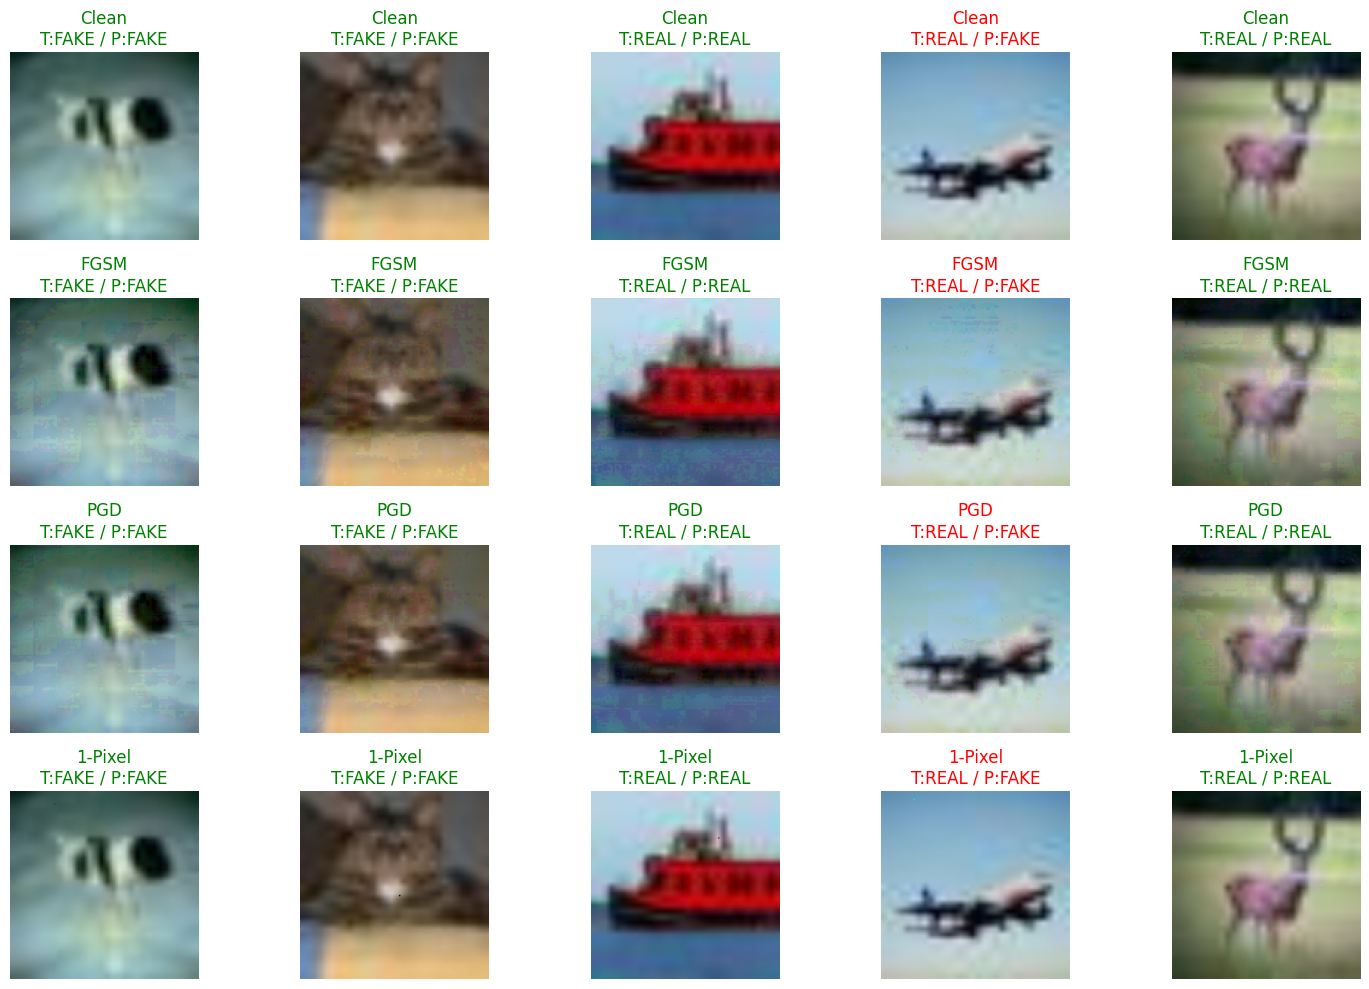

In [20]:
# Cell 9 — Visualize Predictions
variants   = ['Clean', 'FGSM', 'PGD', '1-Pixel']
all_imgs   = [images, images_fgsm, images_pgd, images_pixel]
all_preds  = [pred_clean, pred_fgsm, pred_pgd, pred_pixel]

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
sample_idxs = random.sample(range(NUM_SAMPLES), 5)

for row, (title, img_set, preds) in enumerate(zip(variants, all_imgs, all_preds)):
    for col, idx in enumerate(sample_idxs):
        img = img_set[idx].detach().cpu().permute(1, 2, 0).numpy()
        t_label = CLASS_NAMES[true_labels[idx]]
        p_label = CLASS_NAMES[preds[idx]]
        color = 'green' if t_label == p_label else 'red'
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{title}\nT:{t_label} / P:{p_label}", color=color)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()
